In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle

data_path = 'files_to_analyze'
output_path = 'output'

In [5]:
# Load pickle data and initialize for analysis



# Files for multi-session analysis
pickle_files = ['output/240404-1_data.pickle','output/240404-2_data.pickle','output/240404-3_data.pickle','output/240404-4_data.pickle','output/240404-5_data.pickle']


# Load the session data from the pickle file
with open(pickled_test_data, 'rb') as pickle_file:
    session_data = pickle.load(pickle_file)

# Access session-wide information
session_info = session_data['session_info']
session_name = session_info['session_name']
num_channels = session_info['num_channels']
scan_rate = session_info['scan_rate']
num_samples = session_info['num_samples']
stim_duration = session_info['stim_duration']
stim_interval = session_info['stim_interval']
emg_amp_gains = session_info['emg_amp_gains']

print(f"Session Name: {session_name}")
print(f"# of Channels: {num_channels}")
print(f"Scan rate (Hz): {scan_rate}")
print(f"Samples/Channel: {num_samples}")
print(f"Stimulus duration (ms): {stim_duration}")
print(f"Stimulus interval (s): {stim_interval}")
print(f"EMG amp gains: {emg_amp_gains}")

# # Access recordings
# recordings = session_data['recordings']
# for recording in recordings:
#     stimulus_v = recording['stimulus_v']
#     channel_data = recording['channel_data']
#     print(f"Stimulus Voltage: {stimulus_v}")
#     for i, channel_data_array in enumerate(channel_data):
#         print(f"Channel {i} data length: {len(channel_data_array)}")

Session Name: 240404-4
# of Channels: 2
Scan rate (Hz): 10000
Samples/Channel: 1510
Stimulus duration (ms): 0.1
Stimulus interval (s): 3.0
EMG amp gains: [500, 500, 500, 500, 500, 500]


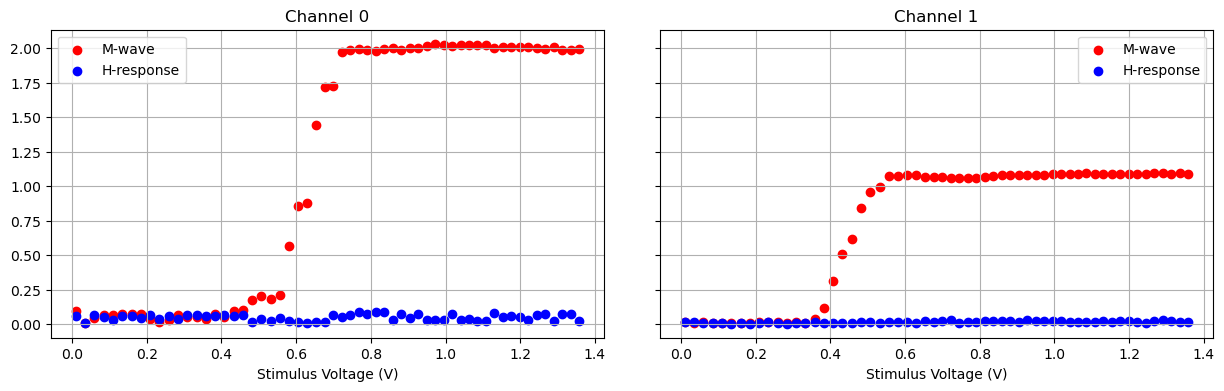

In [58]:
# Plot Stimulus-M/H Curves from single recording session

def rectify_emg(data):
    """
    Rectify EMG data by taking the absolute value.
    """
    return np.abs(data)

def calculate_average_amplitude(emg_data, start_ms, end_ms, scan_rate):
    """
    Calculate the average rectified EMG amplitude between start_ms and end_ms.
    """
    start_index = int(start_ms * scan_rate / 1000)
    end_index = int(end_ms * scan_rate / 1000)
    emg_window = emg_data[start_index:end_index]
    rectified_emg_window = rectify_emg(emg_window)
    return np.mean(rectified_emg_window)

# Load the session data from the pickle file
with open(pickled_test_data, 'rb') as pickle_file:
    session_data = pickle.load(pickle_file)

# Access session-wide information
session_info = session_data['session_info']
scan_rate = session_info['scan_rate']
num_channels = session_info['num_channels']

# Access recordings and sort by stimulus_value
recordings = sorted(session_data['recordings'], key=lambda x: x['stimulus_v'])

# Define the time windows for M-wave and H-response
m_start_ms = 2  # Start time for M-wave (in ms)
m_end_ms = 4  # End time for M-wave (in ms)
h_start_ms = 4  # Start time for H-response (in ms)
h_end_ms = 7  # End time for H-response (in ms)

# Create a figure and axis
if num_channels == 1:
    fig, ax = plt.subplots(figsize=(8, 4))
    axes = [ax]
else:
    fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(15, 4), sharey=True)

# Plot the M-wave and H-response amplitudes for each channel
for channel_index in range(num_channels):
    m_wave_amplitudes = []
    h_response_amplitudes = []
    stimulus_voltages = []

    for recording in recordings:
        channel_data = recording['channel_data'][channel_index]
        stimulus_v = recording['stimulus_v']

        m_wave_amplitude = calculate_average_amplitude(channel_data, m_start_ms, m_end_ms, scan_rate)
        h_response_amplitude = calculate_average_amplitude(channel_data, h_start_ms, h_end_ms, scan_rate)

        m_wave_amplitudes.append(m_wave_amplitude)
        h_response_amplitudes.append(h_response_amplitude)
        stimulus_voltages.append(stimulus_v)

    if num_channels == 1:
        ax.scatter(stimulus_voltages, m_wave_amplitudes, color='r', label='M-wave', marker='o')
        ax.scatter(stimulus_voltages, h_response_amplitudes, color='b', label='H-response', marker='o')
        ax.set_title('Channel 0')
        ax.set_xlabel('Stimulus Voltage (V)')
        ax.set_ylabel('Amplitude (mV)')
        ax.grid(True)
        ax.legend()
    else:
        axes[channel_index].scatter(stimulus_voltages, m_wave_amplitudes, color='r', label='M-wave', marker='o')
        axes[channel_index].scatter(stimulus_voltages, h_response_amplitudes, color='b', label='H-response', marker='o')
        axes[channel_index].set_title(f'Channel {channel_index}')
        axes[channel_index].set_xlabel('Stimulus Voltage (V)')
        axes[channel_index].grid(True)
        axes[channel_index].legend()

# Adjust subplot spacing (only if there are multiple channels)
if num_channels > 1:
    plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()

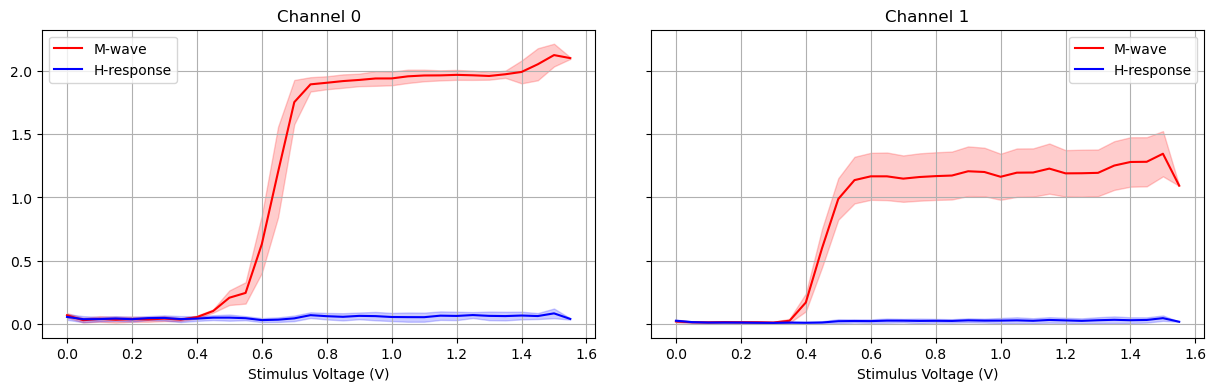

In [57]:
# Plot Stimulus-M/H Curves from multiple recording sessions (same plot)

bin_size= 0.05 # bin size for stimulus voltage

def rectify_emg(data):
    """
    Rectify EMG data by taking the absolute value.
    """
    return np.abs(data)

def calculate_average_amplitude(emg_data, start_ms, end_ms, scan_rate):
    """
    Calculate the average rectified EMG amplitude between start_ms and end_ms.
    """
    start_index = int(start_ms * scan_rate / 1000)
    end_index = int(end_ms * scan_rate / 1000)
    emg_window = emg_data[start_index:end_index]
    rectified_emg_window = rectify_emg(emg_window)
    return np.mean(rectified_emg_window)

def calculate_mean_std(recordings, stimulus_value, channel_index, m_start_ms, m_end_ms, h_start_ms, h_end_ms, scan_rate, bin_size=0.1):
    """
    Calculate the M-responses and H-reflexes over multiple sessions, binning the stimulus voltages.
    """
    m_wave_amplitudes = []
    h_response_amplitudes = []
    for recording in recordings:
        binned_stimulus_v = round(recording['stimulus_v'] / bin_size) * bin_size
        if binned_stimulus_v == stimulus_value:
            channel_data = recording['channel_data'][channel_index]
            m_wave_amplitude = calculate_average_amplitude(channel_data, m_start_ms, m_end_ms, scan_rate)
            h_response_amplitude = calculate_average_amplitude(channel_data, h_start_ms, h_end_ms, scan_rate)
            m_wave_amplitudes.append(m_wave_amplitude)
            h_response_amplitudes.append(h_response_amplitude)
    m_wave_mean = np.mean(m_wave_amplitudes)
    m_wave_std = np.std(m_wave_amplitudes)
    h_response_mean = np.mean(h_response_amplitudes)
    h_response_std = np.std(h_response_amplitudes)
    return m_wave_mean, m_wave_std, h_response_mean, h_response_std

# Load the session data from the pickle file
recordings = []
for session in pickle_files:
    with open(session, 'rb') as pickle_file:
        session_data = pickle.load(pickle_file)

    # Access session-wide information
    session_info = session_data['session_info']
    scan_rate = session_info['scan_rate']
    num_channels = session_info['num_channels']

    # Access recordings and sort by stimulus_value
    recordings.extend(sorted(session_data['recordings'], key=lambda x: x['stimulus_v']))

sorted_recordings = sorted(recordings, key=lambda x: x['stimulus_v'])
# Define the time windows for M-wave and H-response
m_start_ms = 2  # Start time for M-wave (in ms)
m_end_ms = 4  # End time for M-wave (in ms)
h_start_ms = 4  # Start time for H-response (in ms)
h_end_ms = 7  # End time for H-response (in ms)

# Create a figure and axis
if num_channels == 1:
    fig, ax = plt.subplots(figsize=(8, 4))
    axes = [ax]
else:
    fig, axes = plt.subplots(nrows=1, ncols=num_channels, figsize=(15, 4), sharey=True)

# Get unique binned stimulus voltages
stimulus_voltages = sorted(list(set([round(recording['stimulus_v'] / bin_size) * bin_size for recording in sorted_recordings])))

# Plot the M-wave and H-response amplitudes for each channel
for channel_index in range(num_channels):
    m_wave_means = []
    m_wave_stds = []
    h_response_means = []
    h_response_stds = []
    for stimulus_v in stimulus_voltages:
        m_wave_mean, m_wave_std, h_response_mean, h_response_std = calculate_mean_std(sorted_recordings, stimulus_v, channel_index, m_start_ms, m_end_ms, h_start_ms, h_end_ms, scan_rate, bin_size)
        m_wave_means.append(m_wave_mean)
        m_wave_stds.append(m_wave_std)
        h_response_means.append(h_response_mean)
        h_response_stds.append(h_response_std)

    if num_channels == 1:
        ax.plot(stimulus_voltages, m_wave_means, color='r', label='M-wave')
        ax.fill_between(stimulus_voltages, np.array(m_wave_means) - np.array(m_wave_stds), np.array(m_wave_means) + np.array(m_wave_stds), color='r', alpha=0.2)
        ax.plot(stimulus_voltages, h_response_means, color='b', label='H-response')
        ax.fill_between(stimulus_voltages, np.array(h_response_means) - np.array(h_response_stds), np.array(h_response_means) + np.array(h_response_stds), color='b', alpha=0.2)
        ax.set_title('Channel 0')
        ax.set_xlabel('Stimulus Voltage (V)')
        ax.set_ylabel('Amplitude (mV)')
        ax.grid(True)
        ax.legend()
    else:
        axes[channel_index].plot(stimulus_voltages, m_wave_means, color='r', label='M-wave')
        axes[channel_index].fill_between(stimulus_voltages, np.array(m_wave_means) - np.array(m_wave_stds), np.array(m_wave_means) + np.array(m_wave_stds), color='r', alpha=0.2)
        axes[channel_index].plot(stimulus_voltages, h_response_means, color='b', label='H-response')
        axes[channel_index].fill_between(stimulus_voltages, np.array(h_response_means) - np.array(h_response_stds), np.array(h_response_means) + np.array(h_response_stds), color='b', alpha=0.2)
        axes[channel_index].set_title(f'Channel {channel_index}')
        axes[channel_index].set_xlabel('Stimulus Voltage (V)')
        axes[channel_index].grid(True)
        axes[channel_index].legend()
    
# Adjust subplot spacing (only if there are multiple channels)
if num_channels > 1:
    plt.subplots_adjust(wspace=0.1)

# Show the plot
plt.show()